# Quantum Optimal Control: State Transfer (JAX version)

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time

from arc import Rubidium87
from quantum_optimal_control.state_transfer.propagator_vl import PropagatorVL
from quantum_optimal_control.toolkits.plotting_helper import getStylishFigureAxes, PlotPlotter

np.random.seed(1)

## System Parameters Setup

In [2]:
atom = Rubidium87()

# Intermediate excited state: 6P3/2
n_i = 6
l_i = 1
j_i = 1.5
T_i = atom.getStateLifetime(n_i, l_i, j_i)  # Lifetime of the intermediate state
Gamma_ig = 1/T_i  # Decay rate of the intermediate state

# Rydberg state: 70 S1/2
n_r = 70
l_r = 0
j_r = 0.5
T_rTot = atom.getStateLifetime(n_r, l_r, j_r, temperature=300, includeLevelsUpTo=n_r+50)
T_rRad = atom.getStateLifetime(n_r, l_r, j_r, temperature=0)
T_ri = 1/atom.getTransitionRate(n_r, l_r, j_r, n_i, l_i, j_i, temperature=0)
T_rgp = 1/(1/T_rRad - 1/T_ri)
T_rBB = 1/(1/T_rTot - 1/T_rRad)
Gamma_ri = 1/T_ri
Gamma_rrp = 1/T_rBB
Gamma_rgp = 1/T_rgp
Gamma_rTot = Gamma_ri + Gamma_rrp + Gamma_rgp  # Total decay rate from the Rydberg state

# Control parameters
Rabi_1 = 2 * np.pi * 127e6
Rabi_2 = 2 * np.pi * 127e6
Delta_1 = 0
del_total = 0

# Time grid
t_0 = 0
t_f = 200e-9
nt = 500
delta_t = (t_f - t_0) / nt
tlist = np.linspace(t_0, t_f, nt)

# Basis functions for control amplitudes and optimization parameters
input_dim = 10
num_iters = 500
learn_rate = 0.1
num_ctrls = 5

## Initialize Propagator and Control Parameters

In [3]:
propagatorVL = PropagatorVL(
    input_dim, nt, delta_t, del_total, Delta_1, Rabi_1, Rabi_2,
    Gamma_rTot, Gamma_ig
)

# Initialize control amplitudes for JAX version
ctrl_a = jnp.array(np.random.uniform(-1, 1, (input_dim, num_ctrls)))

# For ctrl_b, set first column in [-1, 1], columns 1-2 in [0, 1], columns 3-4 in [-1, 0]
col0 = np.random.uniform(-1, 1, (input_dim, 1))
col1_2 = np.random.uniform(0, 1, (input_dim, 2))
col3_4 = np.random.uniform(-1, 0, (input_dim, 2))
ctrl_b = jnp.array(np.concatenate([col0, col1_2, col3_4], axis=1))

ctrl_c = jnp.array(np.random.uniform(0, 0.1, (input_dim, num_ctrls)))

# Compute initial cost (figure of merit)
initial_cost = propagatorVL.target(ctrl_a, ctrl_b, ctrl_c)
print('Initial Figure of Merit:', float(initial_cost))

2025-03-14 21:43:50.487812: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Initial Figure of Merit: 0.8022425853500806


## Visualize Initial Control Pulses

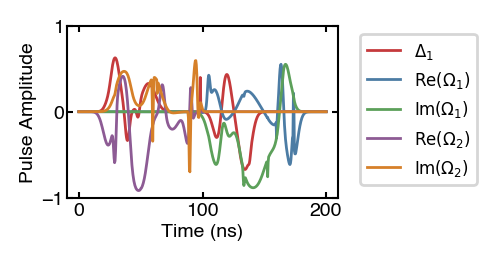

In [4]:
physical_amplitudes_initial = np.array(propagatorVL.return_physical_amplitudes(ctrl_a, ctrl_b, ctrl_c))
labels = [r"$\Delta_1$", r"$\mathrm{Re}(\Omega_1)$", r"$\mathrm{Im}(\Omega_1)$", r"$\mathrm{Re}(\Omega_2)$", r"$\mathrm{Im}(\Omega_2)$"]

fig, ax = getStylishFigureAxes(1, 1)
for ind in range(num_ctrls):
    PlotPlotter(fig, ax, tlist * 1e9, physical_amplitudes_initial[:, ind], style={'label': labels[ind], 'marker': '', 'linestyle': '-', 'linewidth': 1}).draw()
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Pulse Amplitude')
ax.set_yticks([-1, 0, 1])
ax.legend(fontsize=6, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Optimize Control Pulses using JAX Gradient Descent

In [8]:
from jax import jit, value_and_grad

@jit
def optimization_step(ctrl_a, ctrl_b, ctrl_c, lr):
    def loss_fn(a, b, c):
        return propagatorVL.target(a, b, c)
    cost, grads = value_and_grad(loss_fn, argnums=(0,1,2))(ctrl_a, ctrl_b, ctrl_c)
    new_ctrl_a = ctrl_a - lr * grads[0]
    new_ctrl_b = ctrl_b - lr * grads[1]
    new_ctrl_c = ctrl_c - lr * grads[2]
    return cost, new_ctrl_a, new_ctrl_b, new_ctrl_c

best_cost = float('inf')
for step in range(num_iters):
    cost, ctrl_a, ctrl_b, ctrl_c = optimization_step(ctrl_a, ctrl_b, ctrl_c, learn_rate)
    if (step+1) % 50 == 0 or step == 0:
        print(f'Step {step+1}: Figure of Merit = {float(cost):.5f}')
    if float(cost) < best_cost:
        best_cost = float(cost)

print('Optimized Figure of Merit:', best_cost)

Step 1: Figure of Merit = 0.00095
Step 50: Figure of Merit = 0.00089
Step 100: Figure of Merit = 0.00085
Step 150: Figure of Merit = 0.00080


KeyboardInterrupt: 

## Post-Optimization Analysis and Plots

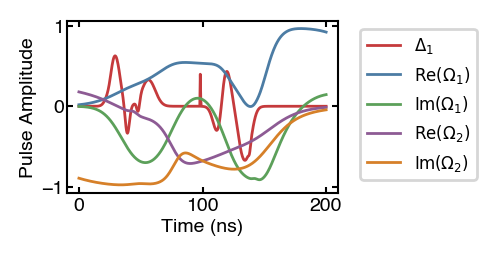

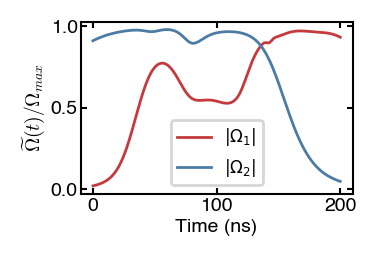

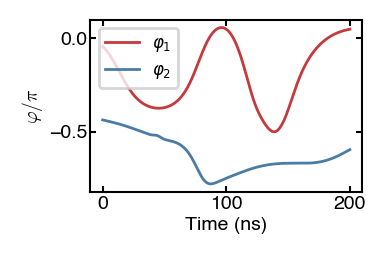

In [ ]:
# Retrieve optimized physical amplitudes
physical_amplitudes_final = np.array(propagatorVL.return_physical_amplitudes(ctrl_a, ctrl_b, ctrl_c))

# Compute Rabi amplitudes from real and imaginary parts
Rabi_1_amplitude = np.sqrt(physical_amplitudes_final[:, 1]**2 + physical_amplitudes_final[:, 2]**2)
Rabi_2_amplitude = np.sqrt(physical_amplitudes_final[:, 3]**2 + physical_amplitudes_final[:, 4]**2)
Rabi_1_phase = np.angle(physical_amplitudes_final[:, 1] + 1j * physical_amplitudes_final[:, 2])
Rabi_2_phase = np.angle(physical_amplitudes_final[:, 3] + 1j * physical_amplitudes_final[:, 4])

# Plot optimized control pulses
fig, ax = getStylishFigureAxes(1, 1)
for ind in range(num_ctrls):
    PlotPlotter(fig, ax, tlist * 1e9, physical_amplitudes_final[:, ind], style={'label': labels[ind], 'marker': '', 'linestyle': '-'}).draw()
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Pulse Amplitude')
ax.legend(fontsize=6, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot computed Rabi amplitudes (magnitudes)
fig, ax = getStylishFigureAxes(1, 1)
PlotPlotter(fig, ax, tlist * 1e9, Rabi_1_amplitude, style={'label': r'$|\Omega_1|$', 'marker': '', 'linestyle': '-'}).draw()
PlotPlotter(fig, ax, tlist * 1e9, Rabi_2_amplitude, style={'label': r'$|\Omega_2|$', 'marker': '', 'linestyle': '-'}).draw()
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'$\widetilde{\Omega}(t)/\Omega_{max}$')
ax.legend(fontsize=6)
plt.show()

# Plot computed phases
fig, ax = getStylishFigureAxes(1, 1)
PlotPlotter(fig, ax, tlist * 1e9, Rabi_1_phase / np.pi, style={'label': r'$\varphi_1$', 'marker': '', 'linestyle': '-'}).draw()
PlotPlotter(fig, ax, tlist * 1e9, Rabi_2_phase / np.pi, style={'label': r'$\varphi_2$', 'marker': '', 'linestyle': '-'}).draw()
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'$\varphi/\pi$')
ax.legend(fontsize=6)
plt.show()

## Compute Dark State Overlap

In [7]:
# Propagate the state using the optimized pulses
exps = propagatorVL.exponentials(ctrl_a, ctrl_b, ctrl_c)
g_prime, r_prime, g, i_state, r = propagatorVL.nLevelAtomBasis(propagatorVL.dim)
current_state = propagatorVL.psi_0
DS_overlap_squared = []
for idx in range(propagatorVL.no_of_steps):
    # Calculate current Rabi frequencies from physical amplitudes
    curr_phys = np.array(propagatorVL.return_physical_amplitudes(ctrl_a, ctrl_b, ctrl_c))
    current_Rabi_1 = Rabi_1 * curr_phys[idx, 1:3]
    current_Rabi_2 = Rabi_2 * curr_phys[idx, 3:5]
    norm_dark = 1.0/np.sqrt(np.sum(np.square(current_Rabi_1.real) + np.square(current_Rabi_1.imag) +
                                  np.square(current_Rabi_2.real) + np.square(current_Rabi_2.imag)))
    dark_state = norm_dark * ((current_Rabi_2[0] + 1j*current_Rabi_2[1]) * g - 
                              (current_Rabi_1[0] - 1j*current_Rabi_1[1]) * r)
    overlap = np.vdot(current_state, dark_state)
    DS_overlap_squared.append(np.real(np.conj(overlap)*overlap))
    # Propagate state
    U_prop = np.array(exps[idx, :propagatorVL.dim, :propagatorVL.dim])
    current_state = U_prop @ current_state

# Plot dark state overlap
fig, ax = getStylishFigureAxes(1, 1)
PlotPlotter(fig, ax, tlist * 1e9, DS_overlap_squared, style={'label': 'Dark State Overlap', 'marker': '', 'linestyle': '-', 'linewidth': 1}).draw()
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'$|\langle D|\psi \rangle|^2$')
plt.show()

KeyboardInterrupt: 